
# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Clean up the data
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
%matplotlib inline
from datetime import timedelta


import warnings
warnings.filterwarnings("ignore")

# Let's forecast champagne sales!

## Step 1: Clean up the data

In [69]:
# read data
df=pd.read_csv('champagne.csv')
df

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


In [70]:
## cleaning up the data

# 1. rename columns
df.rename(columns={'Month':'Date','Perrin Freres monthly champagne sales millions ?64-?72':'Sales'},inplace=True)

# 2. find the index of all NaN values
df.index[df.isna().any(axis=1)]


Int64Index([105, 106], dtype='int64')

In [71]:
# drop rows with NaN values
df.dropna(inplace=True)
# check if there are any NaN values left
df.index[df.isna().any(axis=1)]


    

Int64Index([], dtype='int64')

In [72]:
# convert Month into datetime and set Month as index
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m")
df.index = df["Date"]
df.drop("Date", axis=1, inplace=True)


In [73]:
# use .describe() to inspect the general statistic properties of our data 
df.describe()


,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


## Step 2: Visualize the Data

Text(0, 0.5, 'Sales')

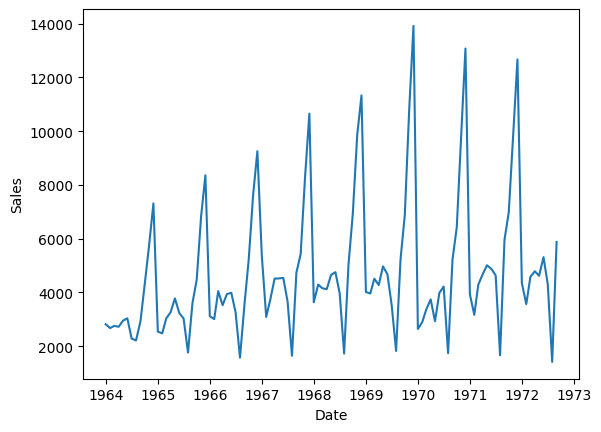

In [74]:
#plot 
plt.plot(df.index,df['Sales'])
#name x and y axis
plt.xlabel('Date')
plt.ylabel('Sales')

> Conclusion: <br> We recognize a clear upward trend and seasonality.

### To be sure, let's test for stationarity with ADF Test.
* H0: It is non stationary
* H1: It is stationary

In [75]:
# use the augmented Dickey-Fuller Test to test for stationarity
# hint: use the adfuller() function
# interpret the output

adfuller(df['Sales'])
#non stationary

(-1.8335930563276188,
 0.363915771660247,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

## Step 3: Make the Time Series Stationary

In [76]:
# Differencing with 1-Month Shift
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)

# Calculate the seasonal differences
df['Seasonal First Difference'] = df['Sales'] - df['Sales'].shift(12)

In [77]:
# show first 14 month to see the results
df.head(14)

,Sales,Sales First Difference,Seasonal First Difference
Date,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [78]:
## Again check the differences for stationarity with ADF Test
# don't forget to drop the NaN values (you can use .dropna())
adfuller(df['Seasonal First Difference'].dropna())



(-7.626619157213166,
 2.0605796968136632e-11,
 0,
 92,
 {'1%': -3.503514579651927,
  '5%': -2.893507960466837,
  '10%': -2.583823615311909},
 1294.7753384560438)

<AxesSubplot: xlabel='Date'>

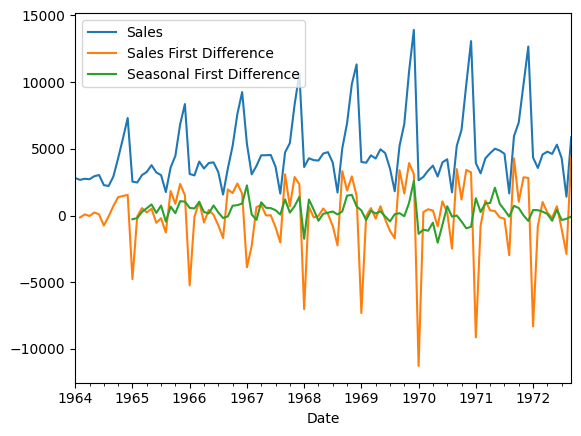

In [79]:
# plot and see by yourself - is it stationary now?
df.plot()

## Step 4: Plot the Autocorrelation and Partial Autocorrelation Charts

> Identification of an __AR model__ is often best done with the __PACF__.
<br><br>
For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

    
> Identification of an __MA model__ is often best done with the __ACF__ rather than the PACF.
<br><br>
For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
(p,d,q) = (AR model lags, differencing, MA lags)

Text(0.5, 1.0, 'PACF')

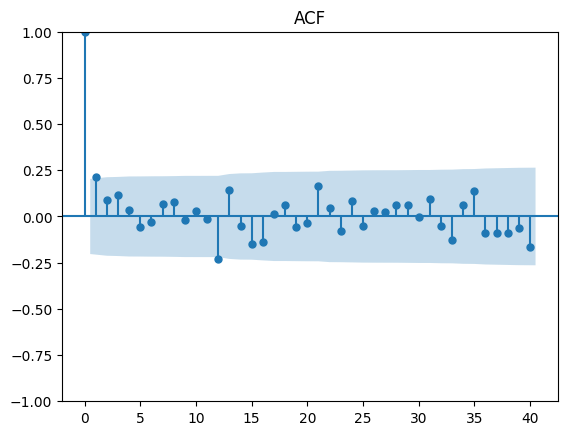

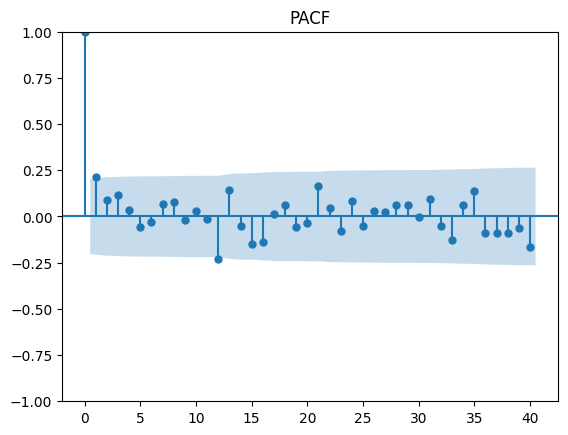

In [80]:
# Plot ACF and PACF with 40 lags each for the Seasonal First Difference
plot_acf(df['Seasonal First Difference'].dropna(), lags=40)
#name the plot
plt.title('ACF')
plot_acf(df['Seasonal First Difference'].dropna(), lags=40)
#name the plot
plt.title('PACF')


## Step 5: Construct the (seasonal) ARIMA

### Define test and training dataset

In [81]:
# use following dates
train_end = datetime(1971,6,1)
test_end = datetime(1972,9,1)

# divide your dataset in train and test data
df_train = df.loc[:train_end]
df_test = df.loc[train_end+timedelta(days=1):test_end]



In [82]:
# Use the column "Sales" for the first Model


### ARIMA

In [83]:
# Lets first fit an ARIMA model with
# p=1, d=1, q=1
# hint: use the function ARIMA()

model_arima = ARIMA(df_train['Sales'], order=(1,1,1))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   90
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -813.015
Date:                Fri, 11 Nov 2022   AIC                           1632.031
Time:                        11:16:44   BIC                           1639.497
Sample:                    01-01-1964   HQIC                          1635.040
                         - 06-01-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4703      0.138      3.405      0.001       0.200       0.741
ma.L1         -0.9631      0.072    -13.348      0.000      -1.105      -0.822
sigma2      4.947e+06   5.96e+05      8.302      0.000    3.78e+06    6.11e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 5.47
Prob(Q):                              0.34   Prob(JB):                         0.06
Heteroskedasticity (H):               4.00   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Non-Rolling Forecast (ARIMA)

<AxesSubplot: xlabel='Date'>

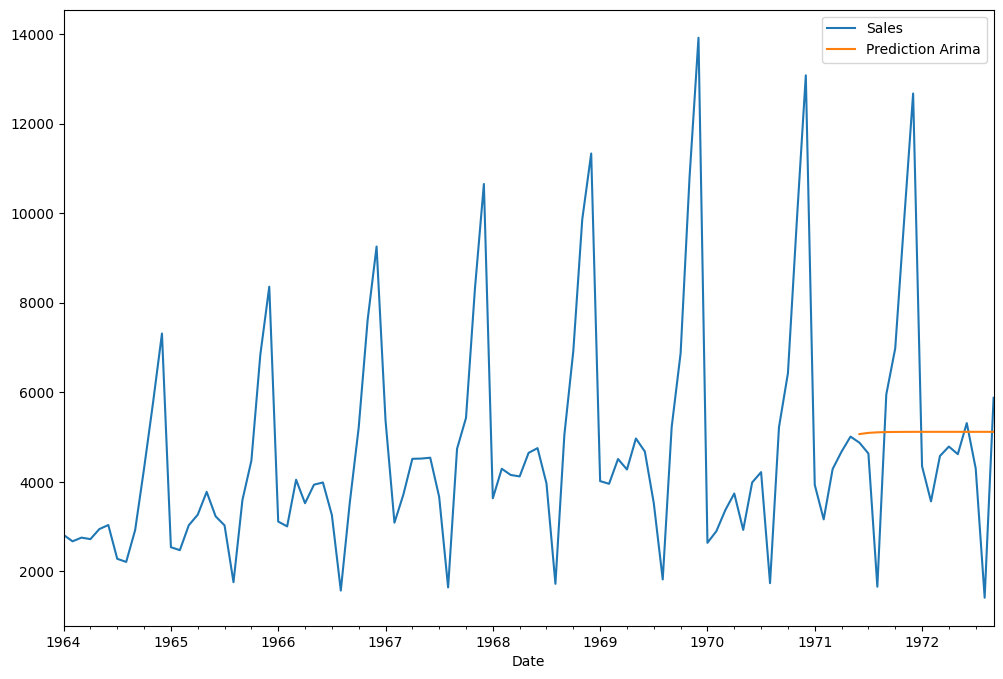

In [84]:
# get the forecast values of the test dataset
# add them to the dataset in a new column
df["Prediction Arima"] = model_arima_fit.predict(start = train_end, end = test_end, dynamic= True, typ = 'levels').rename('ARIMA Predictions')

# plot to compare your forecast to the actual values like below
df[['Sales','Prediction Arima']].plot(figsize=(12,8))



In [99]:
test_end

datetime.datetime(1972, 9, 1, 0, 0)

In [85]:
# calculate residulas and the following errors
# 1. Mean Absolute Percent Error
# 2. Root Mean Squared Error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import math
df_pred = model_arima_fit.predict(start = df_test.index[0], end = df_test.index[-1], dynamic= True, typ = 'levels').rename('ARIMA Predictions')
mape = mean_absolute_percentage_error(df_test["Sales"], df_pred)
mse = mean_squared_error(df_test["Sales"], df_pred)
rmse = math.sqrt(mse)
print("The Mean Absolute Percentage Error is: ", mape)
print("The Root Mean Square Error is: ", rmse)


The Mean Absolute Percentage Error is:  0.49880299878762535
The Root Mean Square Error is:  2760.603320549666


> Conclusion: <br> This out-of sample forecast converges to the mean in the long run. A better approach might be a rolling forecast instead.

### Rolling forecast (ARIMA)

Text(0.5, 1.0, 'Champagne Sale')

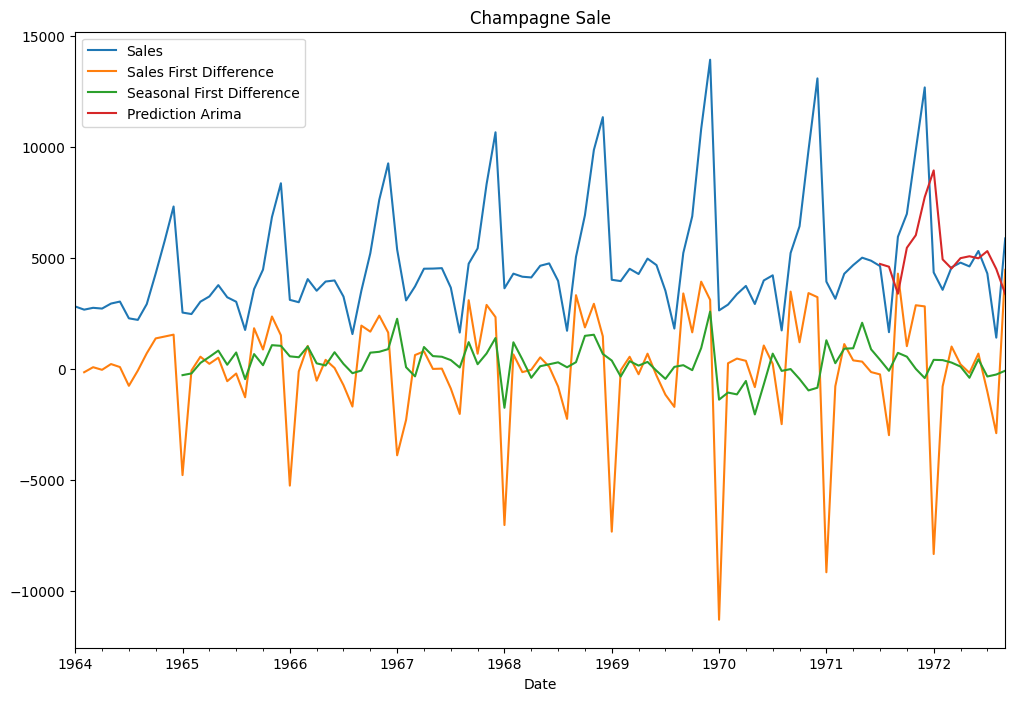

In [86]:
# use a rolling forecast considering the actual data to predict next month
# use a copy of the test data for the rolling predictions
# for every new datapoint you need to fit the AR model again
#iterate over the test data and predict the next month
# add the prediction to the test data
list_pred = []

for i in df_test.index:
    training_data = df["Sales"].loc[:i].copy()
    model_arima = ARIMA(training_data, order=(1,1,1))
    #??
    model_arima_fit = model_arima.fit()
    list_pred.append(model_arima_fit.predict(start = i, end = i, dynamic= True, typ = 'levels')[0])

    
    

#add list_pred to df_test
df_test["Prediction Arima"] = list_pred
#add the df_test["Prediction Arima"] to the df based on the index, fill all NaN values with 0
df["Prediction Arima"] = df_test["Prediction Arima"].dropna()
# plot to compare the rolling forecast with the actual values
df.plot(figsize=(12,8))
plt.title("Champagne Sale")




In [87]:
# calculate residulas and the following errors
# 1. Mean Absolute Percent Error
# 2. Root Mean Squared Error
#df_test.dropna(inplace=True)

mape = mean_absolute_percentage_error(df_test["Sales"], df_test["Prediction Arima"])
mse = mean_squared_error(df_test["Sales"], df_test["Prediction Arima"])
rmse = math.sqrt(mse)
print("The Mean Absolute Percentage Error is: ", mape)  
print("The Root Mean Square Error is: ", rmse)


The Mean Absolute Percentage Error is:  0.5148370124999212
The Root Mean Square Error is:  2538.319520751134


### SARIMA
Now lets integrate the seasonal component.

In [88]:
# use SARIMAX to construct the seasonal ARIMA model
# hint: use the function sm.tsa.statespace.SARIMAX()
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(df_train['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12),verbose=False)
model_sarimax = model_sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99767D+00    |proj g|=  1.02444D-01

At iterate    5    f=  6.94516D+00    |proj g|=  1.83409D-02

At iterate   10    f=  6.93451D+00    |proj g|=  1.48763D-03

At iterate   15    f=  6.93449D+00    |proj g|=  1.19001D-03


 This problem is unconstrained.



At iterate   20    f=  6.93438D+00    |proj g|=  1.02795D-02

At iterate   25    f=  6.92516D+00    |proj g|=  8.29572D-02

At iterate   30    f=  6.91786D+00    |proj g|=  2.59119D-03

At iterate   35    f=  6.91658D+00    |proj g|=  2.23812D-03

At iterate   40    f=  6.91655D+00    |proj g|=  8.21831D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     43      1     0     0   8.218D-06   6.917D+00
  F =   6.9165455273807499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<AxesSubplot: xlabel='Date'>

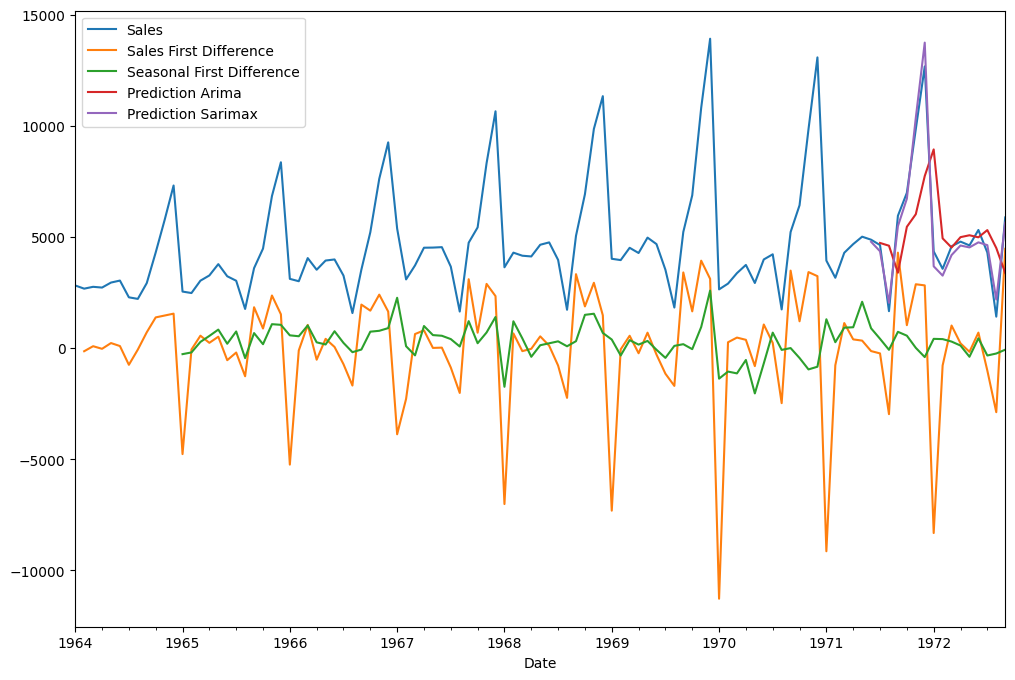

In [89]:
# get SARIMA forecast from test data
#df["Prediction Sarimax"] =
model_sarimax.predict(start = train_end, end = test_end, dynamic= True, typ = 'levels').rename('SARIMA Predictions')
#safe in dataframe
df["Prediction Sarimax"] = model_sarimax.predict(start = train_end, end = test_end, dynamic= True, typ = 'levels').rename('SARIMA Predictions')

# Plot to compare
df.plot(figsize=(12,8))

In [90]:
# calculate residuals and errors
# 1. Mean Absolute Percent Error
# 2. Root Mean Squared Error
df_rm = df.dropna(inplace=False).copy()
df_rm["Error"] = df_rm["Sales"] - df_rm["Prediction Sarimax"]
mape = mean_absolute_percentage_error(df_rm["Sales"], df_rm["Prediction Sarimax"])
mse = mean_squared_error(df_rm["Sales"], df_rm["Prediction Sarimax"])
rmse = math.sqrt(mse)
print("The Mean Absolute Percentage Error is: ", round(mape,4))
print("The Root Mean Square Error is: ", round(rmse,4))

The Mean Absolute Percentage Error is:  0.1125
The Root Mean Square Error is:  497.2416


> Conclusion: <br> The SARIMA with a seasonal component performs much better for this data set. Lets also try a rolling forecast here.

### Rolling forecast (SARIMA)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00461D+00    |proj g|=  1.06551D-01


 This problem is unconstrained.



At iterate    5    f=  6.95434D+00    |proj g|=  2.26326D-02

At iterate   10    f=  6.94306D+00    |proj g|=  1.34064D-03

At iterate   15    f=  6.94304D+00    |proj g|=  8.10008D-04

At iterate   20    f=  6.94245D+00    |proj g|=  2.22978D-02

At iterate   25    f=  6.92461D+00    |proj g|=  1.24459D-02

At iterate   30    f=  6.92395D+00    |proj g|=  8.13446D-03

At iterate   35    f=  6.92386D+00    |proj g|=  7.34310D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     39      1     0     0   7.343D-06   6.924D+00
  F =   6.9238559715379546     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  6.95306D+00    |proj g|=  1.87397D-03

At iterate   15    f=  6.95293D+00    |proj g|=  2.62545D-04

At iterate   20    f=  6.95291D+00    |proj g|=  3.09540D-03

At iterate   25    f=  6.95082D+00    |proj g|=  3.40258D-02

At iterate   30    f=  6.93370D+00    |proj g|=  2.53349D-02

At iterate   35    f=  6.93266D+00    |proj g|=  2.14843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     42      1     0     0   1.316D-06   6.933D+00
  F =   6.9326577654878374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  6.96191D+00    |proj g|=  1.88011D-03

At iterate   15    f=  6.96186D+00    |proj g|=  3.15906D-04

At iterate   20    f=  6.96180D+00    |proj g|=  7.71996D-03

At iterate   25    f=  6.95706D+00    |proj g|=  3.78418D-02

At iterate   30    f=  6.94323D+00    |proj g|=  2.56558D-02

At iterate   35    f=  6.94256D+00    |proj g|=  5.94232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     43      1     0     0   1.936D-05   6.942D+00
  F =   6.9423671535472806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.97405D+00    |proj g|=  2.03359D-02

At iterate   10    f=  6.96819D+00    |proj g|=  2.27111D-03

At iterate   15    f=  6.96812D+00    |proj g|=  3.40034D-04

At iterate   20    f=  6.96808D+00    |proj g|=  4.61700D-03

At iterate   25    f=  6.96537D+00    |proj g|=  3.11932D-02

At iterate   30    f=  6.95031D+00    |proj g|=  9.46437D-03

At iterate   35    f=  6.94857D+00    |proj g|=  2.04478D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     42      1     0     0   3.614D-05   6.949D+00
  F =   6.9485702178102029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03470D+00    |proj g|=  9.36614D-02

At iterate    5    f=  6.98515D+00    |proj g|=  2.30209D-02

At iterate   10    f=  6.97705D+00    |proj g|=  6.44428D-04

At iterate   15    f=  6.97703D+00    |proj g|=  2.80432D-04

At iterate   20    f=  6.97679D+00    |proj g|=  1.68750D-02

At iterate   25    f=  6.96232D+00    |proj g|=  8.21373D-02

At iterate   30    f=  6.95814D+00    |proj g|=  2.89836D-03

At iterate   35    f=  6.95811D+00    |proj g|=  8.72891D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   15    f=  6.98875D+00    |proj g|=  3.12877D-04

At iterate   20    f=  6.98871D+00    |proj g|=  3.66366D-03

At iterate   25    f=  6.98641D+00    |proj g|=  9.84179D-03

At iterate   30    f=  6.97170D+00    |proj g|=  3.64644D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     38      1     0     0   5.922D-06   6.972D+00
  F =   6.9716752987833468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  7.00006D+00    |proj g|=  1.83711D-03

At iterate   15    f=  7.00000D+00    |proj g|=  1.68356D-03

At iterate   20    f=  6.99920D+00    |proj g|=  1.88005D-02

At iterate   25    f=  6.98517D+00    |proj g|=  6.43672D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     32      1     0     0   1.320D-05   6.985D+00
  F =   6.9851296152336060     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  7.00570D+00    |proj g|=  5.63614D-04

At iterate   15    f=  7.00567D+00    |proj g|=  8.57779D-04

At iterate   20    f=  7.00170D+00    |proj g|=  1.90228D-02

At iterate   25    f=  6.99079D+00    |proj g|=  3.09073D-03

At iterate   30    f=  6.99071D+00    |proj g|=  7.35680D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     36      1     0     0   1.948D-06   6.991D+00
  F =   6.9907103762163683     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.01437D+00    |proj g|=  2.11754D-02

At iterate   10    f=  7.01130D+00    |proj g|=  2.41082D-04

At iterate   15    f=  7.01129D+00    |proj g|=  2.96414D-03

At iterate   20    f=  7.00943D+00    |proj g|=  3.34037D-02

At iterate   25    f=  6.99774D+00    |proj g|=  7.02761D-03

At iterate   30    f=  6.99654D+00    |proj g|=  6.28641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     37      1     0     0   5.977D-06   6.996D+00
  F =   6.9964702763547466     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  7.01901D+00    |proj g|=  1.87560D-02

At iterate   10    f=  7.01646D+00    |proj g|=  2.43113D-04

At iterate   15    f=  7.01614D+00    |proj g|=  1.00232D-02

At iterate   20    f=  7.00488D+00    |proj g|=  2.94501D-02

At iterate   25    f=  7.00160D+00    |proj g|=  5.27674D-04

At iterate   30    f=  7.00159D+00    |proj g|=  6.03801D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     37      1     0     0   6.038D-06   7.002D+00
  F =   7.0015936609081111     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.05082D+00    |proj g|=  7.72509D-02

At iterate    5    f=  7.02486D+00    |proj g|=  1.86019D-02

At iterate   10    f=  7.02243D+00    |proj g|=  2.50077D-04

At iterate   15    f=  7.02186D+00    |proj g|=  5.33955D-03

At iterate   20    f=  7.00957D+00    |proj g|=  2.56116D-02

At iterate   25    f=  7.00673D+00    |proj g|=  2.35399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   

 This problem is unconstrained.



At iterate   15    f=  7.02888D+00    |proj g|=  1.74308D-03

At iterate   20    f=  7.02467D+00    |proj g|=  1.32199D-02

At iterate   25    f=  7.01334D+00    |proj g|=  2.57223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   9.935D-06   7.013D+00
  F =   7.0132759898134411     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06338D+00    |proj g|=  4.99988D-02

At iterate    5    f=  7.03924D+00    |proj g|=  1.05997D-02

At iterate   10    f=  7.03728D+00    |proj g|=  3.91855D-04

At iterate   15    f=  7.03718D+00    |proj g|=  4.54829D-03

At iterate   20    f=  7.02872D+00    |proj g|=  2.52289D-02

At iterate   25    f=  7.02240D+00    |proj g|=  4.78994D-03

At iterate   30    f=  7.02234D+00    |proj g|=  1.01991D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   15    f=  7.04265D+00    |proj g|=  6.23150D-03

At iterate   20    f=  7.03772D+00    |proj g|=  5.64381D-02

At iterate   25    f=  7.02815D+00    |proj g|=  1.46567D-03

At iterate   30    f=  7.02802D+00    |proj g|=  1.37755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   5.829D-06   7.028D+00
  F =   7.0280158578068530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  7.04713D+00    |proj g|=  2.99459D-04

At iterate   15    f=  7.04708D+00    |proj g|=  5.05910D-03

At iterate   20    f=  7.04413D+00    |proj g|=  1.18413D-02

At iterate   25    f=  7.03252D+00    |proj g|=  1.06311D-03

At iterate   30    f=  7.03240D+00    |proj g|=  5.50927D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   1.412D-05   7.032D+00
  F =   7.0324006467415403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Text(0.5, 1.0, 'Champagne Sale')

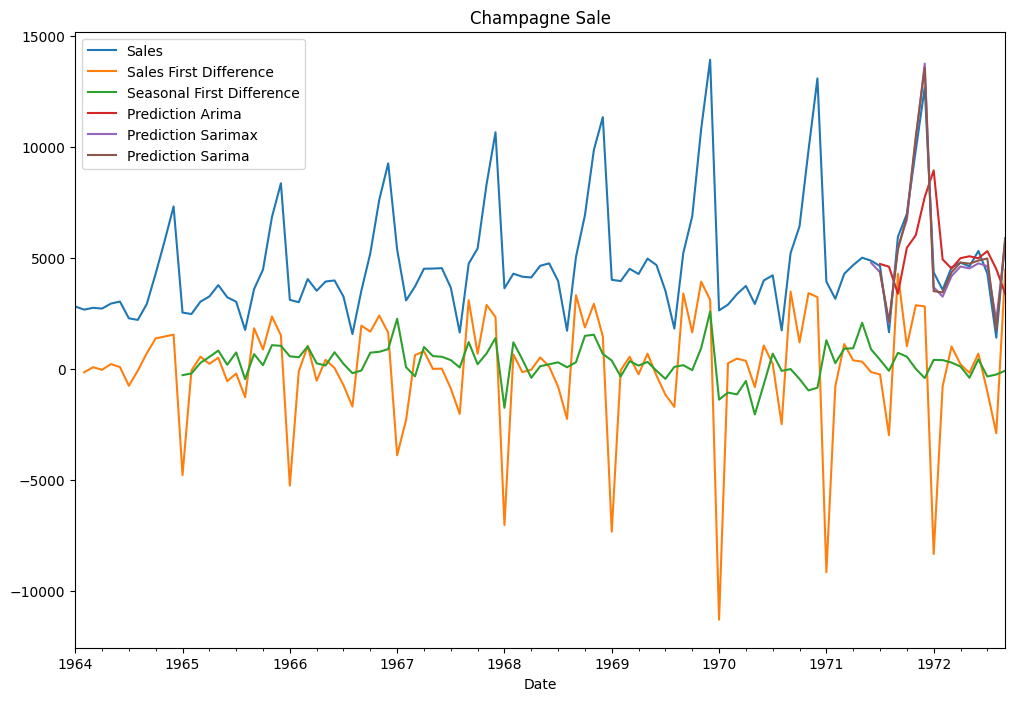

In [91]:
# use a rolling forecast considering the actual data to predict next month
# use a copy of the test data for the rolling predictions
# for every new datapoint you need to fit the AR model again
#iterate over the test data and predict the next month
# add the prediction to the test data
#supress any text output

list_pred = []

for i in df_test.index:
    training_data = df["Sales"].loc[:i].copy()
    model_sarimax = SARIMAX(training_data, order=(1,1,1), seasonal_order=(1,1,1,12),verbose=False)
    model_sarimax = model_sarimax.fit(verbose=False)
    list_pred.append(model_sarimax.predict(start = i, end = i, dynamic= True, typ = 'levels', verbose = False)[0])
    
    

#add list_pred to df_test
df_test["Prediction Sarima"] = list_pred
#add the df_test["Prediction Arima"] to the df based on the index, fill all NaN values with 0
df["Prediction Sarima"] = df_test["Prediction Sarima"]#.dropna()
# plot to compare the rolling forecast with the actual values
df.plot(figsize=(12,8))
plt.title("Champagne Sale")




In [92]:
# calculate residuals and errors metrics
# 1. Mean Absolute Percent Error
# 2. Root Mean Squared Error
df_rm = df.dropna(inplace=False).copy()
df_rm["Error"] = df_rm["Sales"] - df_rm["Prediction Sarimax"]
mape = mean_absolute_percentage_error(df_rm["Sales"], df_rm["Prediction Sarima"])  
mse = mean_squared_error(df_rm["Sales"], df_rm["Prediction Sarima"])   
rmse = math.sqrt(mse)
print("The Mean Absolute Percentage Error is: ", round(mape,4))
print("The Root Mean Square Error is: ", round(rmse,4))


The Mean Absolute Percentage Error is:  0.0913
The Root Mean Square Error is:  470.0995


<AxesSubplot: xlabel='Date'>

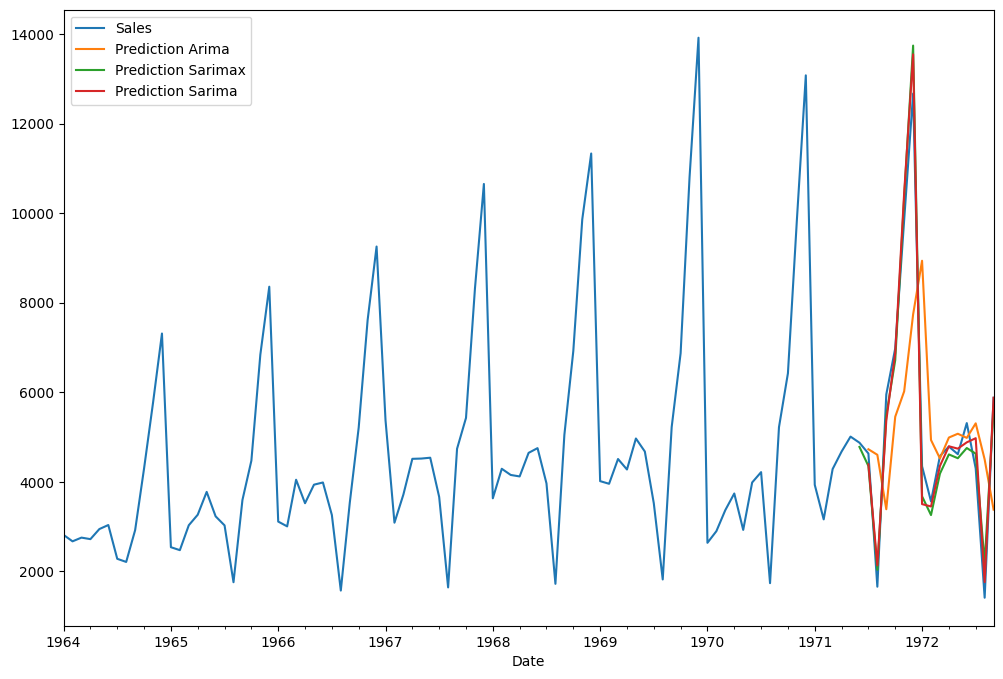

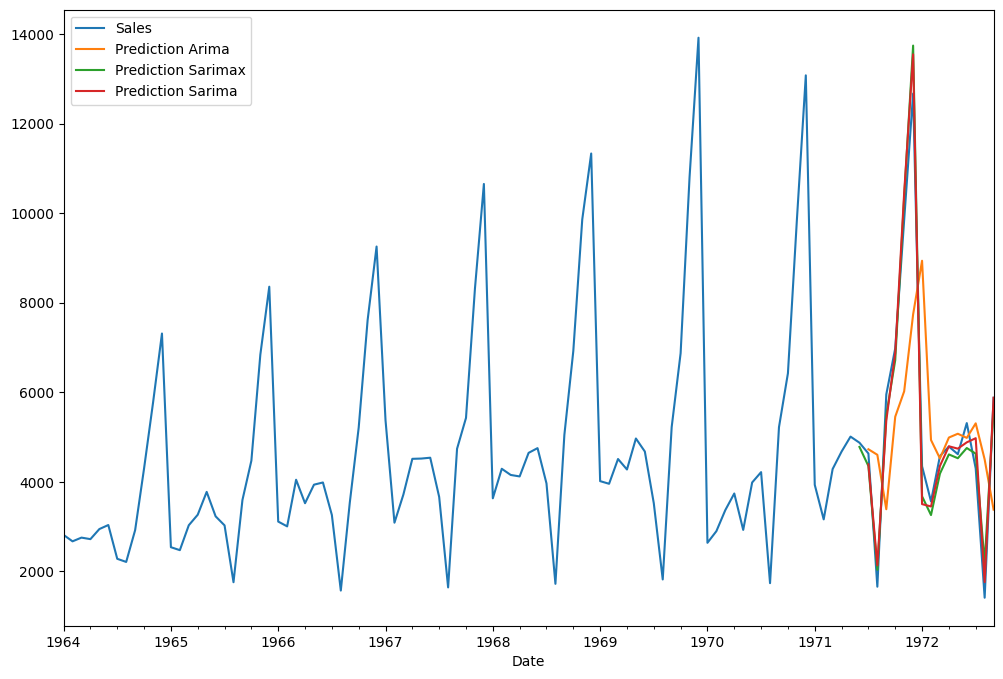

In [129]:
df.plot(figsize=(12,8))
try:
    df = df.drop(columns=["Sales First Difference", "Seasonal First Difference"])
except:
    pass
df.plot(figsize=(12,8))

This looks very promising now. Let's now predict 24 months into the future.

## Step 6: Predict further into the future

In [130]:
# create new dates and add them to the existing dataframe 
# hint: use the function pd.date_range()
#start with the last date from the existing dataframe
from dateutil.relativedelta import relativedelta
dates = pd.date_range(start=df.index.tolist()[-1], end=(df.index.tolist()[-1] + relativedelta(years=3)), freq='MS')
#append them to the dataframe as new rows
df_new = pd.DataFrame(index=dates)
#append the new dataframe to the existing one
df_pred = df.copy()
df_pred = df.append(df_new)
#drop rows with duplicate index
df_pred = df_pred[~df_pred.index.duplicated(keep='first')]
#df_pred = df_pred.dropna(inplace=False)




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07295D+00    |proj g|=  4.80911D-02

At iterate    5    f=  7.04942D+00    |proj g|=  1.53381D-02


 This problem is unconstrained.



At iterate   10    f=  7.04713D+00    |proj g|=  2.99459D-04

At iterate   15    f=  7.04708D+00    |proj g|=  5.05910D-03

At iterate   20    f=  7.04413D+00    |proj g|=  1.18413D-02

At iterate   25    f=  7.03252D+00    |proj g|=  1.06311D-03

At iterate   30    f=  7.03240D+00    |proj g|=  5.50927D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   1.412D-05   7.032D+00
  F =   7.0324006467415403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Text(0.5, 1.0, 'Champagne Sale')

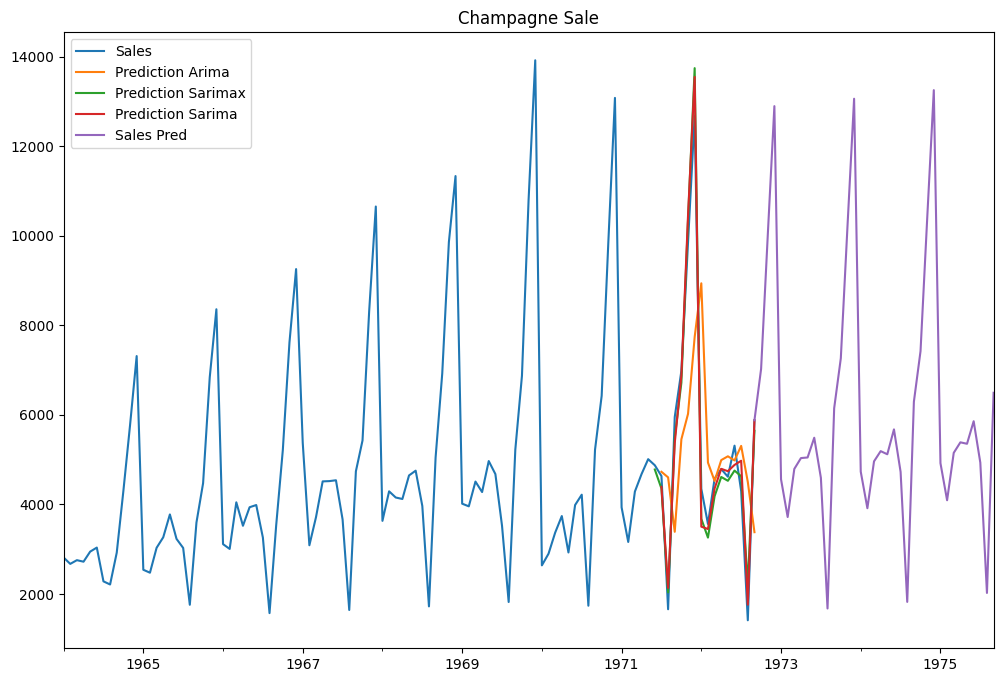

In [131]:
# fit SARIMA model on the whole dataset and predict for the new set of dates into the future
#fit the model with the data from df        
model_sarimax = SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12),verbose=False)
model_sarimax = model_sarimax.fit()
#predict the future
df_pred["Sales Pred"] = model_sarimax.predict(start = df.index.tolist()[-1], end = df_pred.index.tolist()[-1], dynamic= True, typ = 'levels', verbose = False).rename('SARIMA Predictions')

# plot to compare
df_pred.plot(figsize=(12,8))
plt.title("Champagne Sale")
